Example observation: ((9, 10, 0), {})
Basic Policy Win Rate: 42.60%


100%|██████████| 1000/1000 [00:00<00:00, 14495.81it/s]


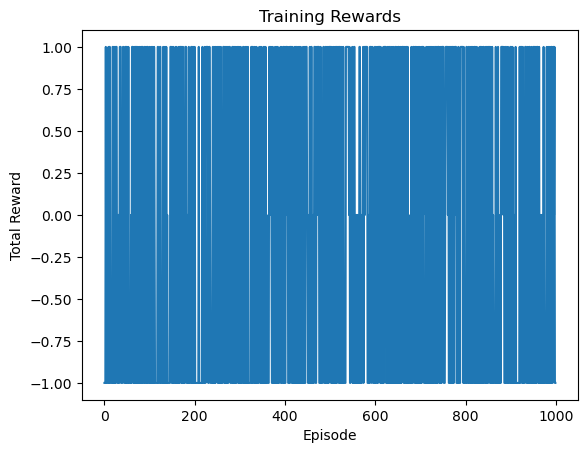

In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Debugging observation structure
print("Example observation:", env.reset())

# Update basic_policy function based on observed structure
def basic_policy(observation):
    if isinstance(observation, tuple) and len(observation) > 0:
        player_sum = observation[0]  # Extract player's hand sum
        return 0 if player_sum >= 17 else 1  # Stick (0) or Hit (1)
    else:
        raise ValueError("Unexpected observation structure:", observation)

# Simulate games using the basic policy
def simulate_basic_policy(env, num_episodes=1000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_episodes):
        observation, _ = env.reset()  # Reset the environment (returns observation and info)
        done = False

        while not done:
            action = basic_policy(observation)
            observation, reward, done, _, _ = env.step(action)

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    win_rate = wins / num_episodes
    print(f"Basic Policy Win Rate: {win_rate * 100:.2f}%")
    return win_rate

# Evaluate the basic policy
basic_policy_win_rate = simulate_basic_policy(env)


# Reinforcement learning agent using Q-learning
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = {}

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = [self.get_q(state, a) for a in range(self.env.action_space.n)]
            return np.argmax(q_values)

    def update_q(self, state, action, reward, next_state, done):
        max_next_q = max([self.get_q(next_state, a) for a in range(self.env.action_space.n)], default=0)
        target = reward + (self.gamma * max_next_q * (not done))
        self.q_table[(state, action)] = self.get_q(state, action) + self.alpha * (target - self.get_q(state, action))

    # Update the Q-learning training loop
    def train(self, num_episodes=1000):
        rewards = []
        for episode in tqdm(range(num_episodes)):
            state, _ = self.env.reset()  # Reset the environment
            total_reward = 0
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated  # Combine termination and truncation
                self.update_q(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)

        return rewards

    # Update the evaluation loop
    def evaluate_agent(agent, env, num_episodes=1000):
        wins = 0
        losses = 0
        draws = 0

        for _ in range(num_episodes):
            state, _ = env.reset()  # Reset the environment
            done = False

            while not done:
                action = np.argmax([agent.get_q(state, a) for a in range(env.action_space.n)])
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated  # Combine termination and truncation
                state = next_state

            if reward > 0:
                wins += 1
            elif reward < 0:
                losses += 1
            else:
                draws += 1

        win_rate = wins / num_episodes
        print(f"Q-learning Agent Win Rate: {win_rate * 100:.2f}%")
        return win_rate


# Initialize and train the Q-learning agent
agent = QLearningAgent(env)
rewards = agent.train(1000)  # Store the returned rewards globally

# Plotting the rewards during training
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.show()

